# Sep 15th, 2021

**Motivation**: PCA analysis on similarity matrix $Y_{ij}$ <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

In [3]:
k = 5
p = 20
svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
group_dir = get_svinet_group_dir(
    results_dir=mice.cfg.results_dir,
    k=k,
    p=p,
    graph_type=svinet_props.get('graph_type', 'real'),
)
print(group_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/gr
oup_results/real-p20-k5

## Load group results

In [4]:
available = [
    e for e in os.listdir(group_dir)
    if '(0.2,1.0;4)' in e
]
file = sorted(available, key=sort_date_latest)[-1]
group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

print(file)

group_bins(0.2,1.0;4)_(2021_09_15).npy

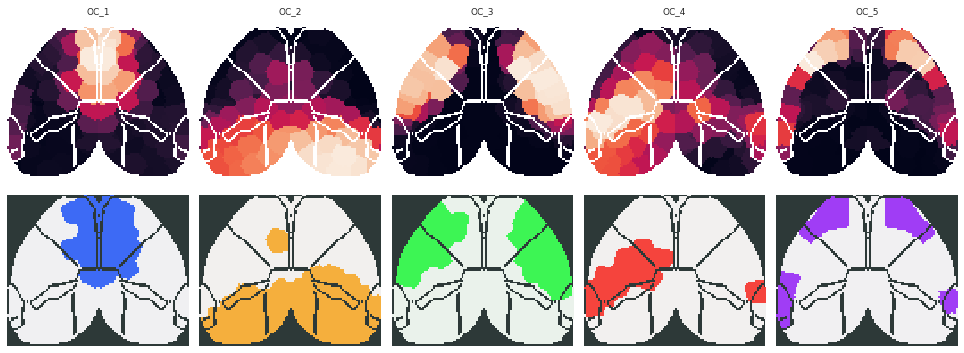

In [5]:
svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
svinet.show(group['pi_avg'], figsize=(13.5, 5.2))

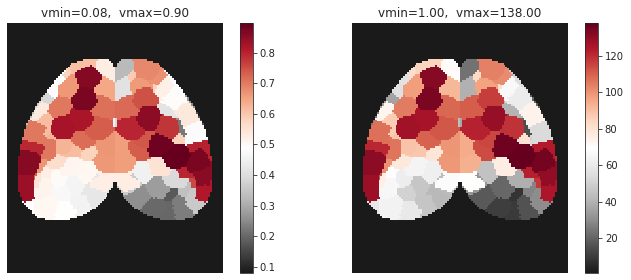

In [6]:
eh = entropy_expect_beta(group['gam_avg'])
ehr = sp_stats.rankdata(eh)

fig, axes = create_figure(1, 2, (10, 4))

for i, ax in enumerate(axes.ravel()):
    data2plt = eh if i == 0 else ehr
    mask = svinet.pi2arr(data2plt.reshape(1, -1), cortex_only=True)[1]
    im = ax.imshow(mask, vmin=min(data2plt), vmax=max(data2plt), cmap='RdGy_r')
    plt.colorbar(im, ax=ax)
    ax.set_title(f"vmin={min(data2plt):0.2f},  vmax={max(data2plt):0.2f}")
remove_ticks(axes)

In [7]:
{k: v.shape for k, v in group.items()}

{
    'cut_oc': (10, 3, 976, 5, 4),
    'cut_nodes': (10, 3, 976, 138, 4),
    'intervals': (4,),
    'gam': (10, 3, 5, 138),
    'gam_avg': (5, 138),
    'gam_all': (10, 3, 976, 5, 138),
    'pi': (10, 3, 5, 138),
    'pi_avg': (5, 138),
    'pi_all': (10, 3, 976, 5, 138),
    'lam': (10, 3, 5, 2),
    'lam_avg': (5, 2),
    'lam_all': (10, 3, 976, 5, 2),
    'beta': (10, 3, 5),
    'beta_avg': (5,)
}

## Continue from here: tomorrow Sept 15th

## Compute $Y_{ij}$

In [18]:
y, y_avg = node_sim_matrix(group)
y.shape, y_avg.shape

((10, 138, 138), (138, 138))

In [19]:
np.isnan(y).sum(), np.isnan(y_avg).sum()

(550, 0)

In [9]:
%time pi_vol = svinet.pi2vol(y_avg, cortex_only=True)

CPU times: user 16.2 s, sys: 1.26 s, total: 17.5 s
Wall time: 17.5 s


In [10]:
%time pca_results = node_sim_pca(pi_vol)

CPU times: user 16.6 s, sys: 1.94 s, total: 18.5 s
Wall time: 3.29 s


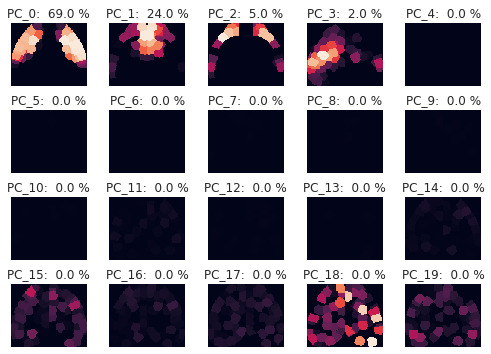

In [11]:
fig, axes = create_figure(4, 5, (7, 5))
for i, ax in enumerate(axes.ravel()):
    arr = pca_results['comps'][i]
    arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
    ax.imshow(arr)
    ax.set_title(f"PC_{i}:  {np.round(100 * pca_results['var_ratio'][i])} %")
remove_ticks(axes)
plt.show()

--------------------------------------------------------------------------------

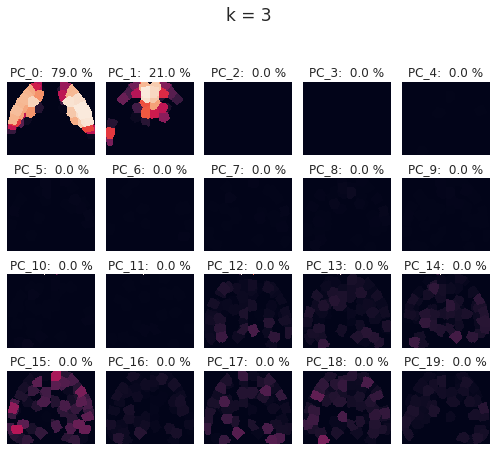

--------------------------------------------------------------------------------

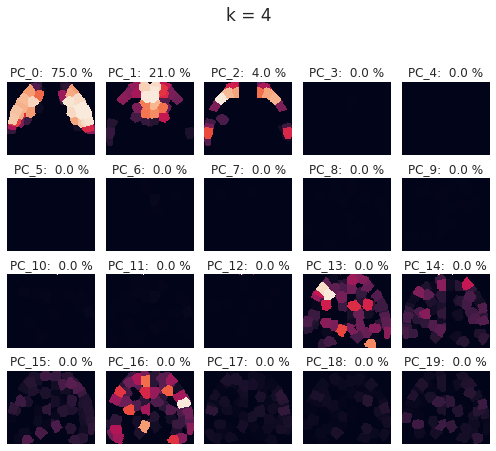

--------------------------------------------------------------------------------

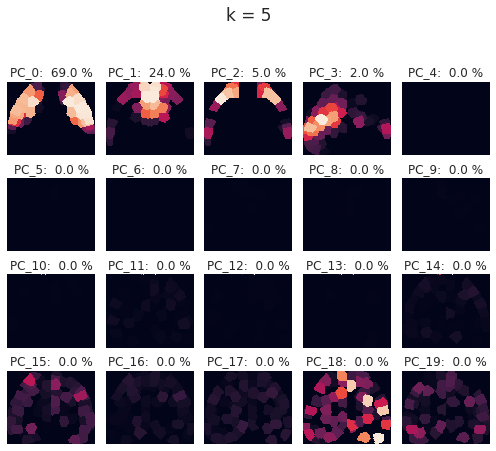

--------------------------------------------------------------------------------

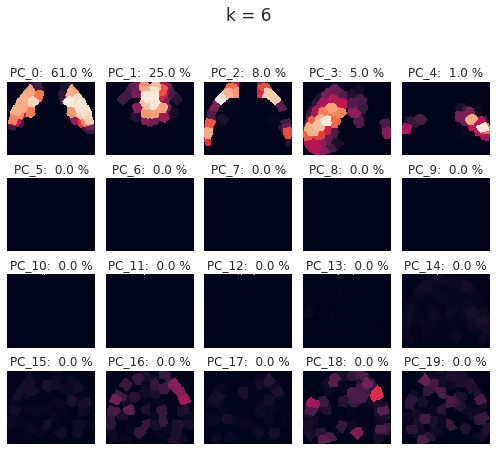

--------------------------------------------------------------------------------

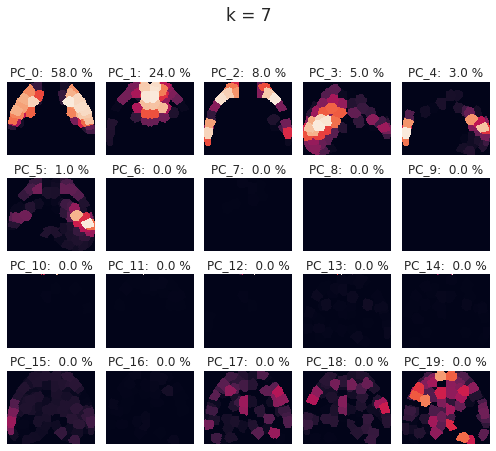

--------------------------------------------------------------------------------

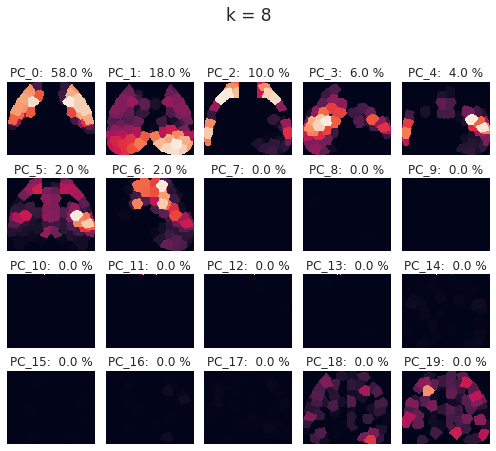

--------------------------------------------------------------------------------

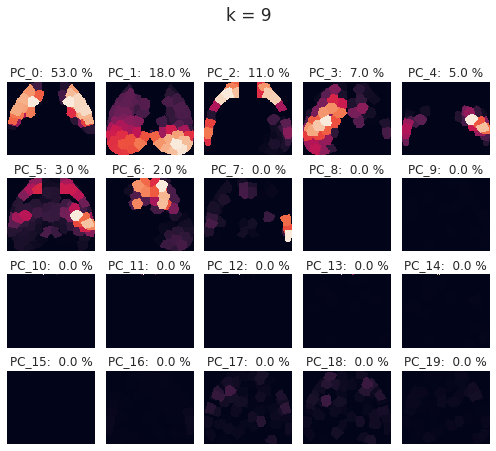

--------------------------------------------------------------------------------

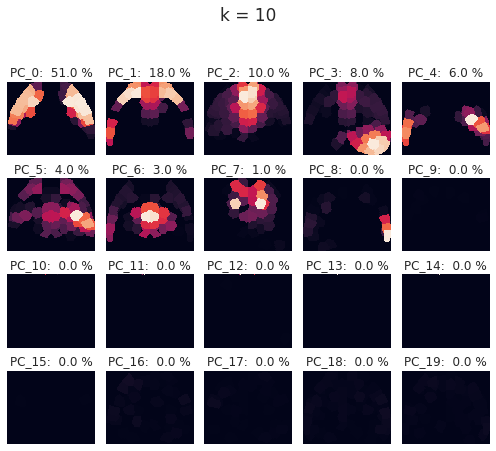

--------------------------------------------------------------------------------

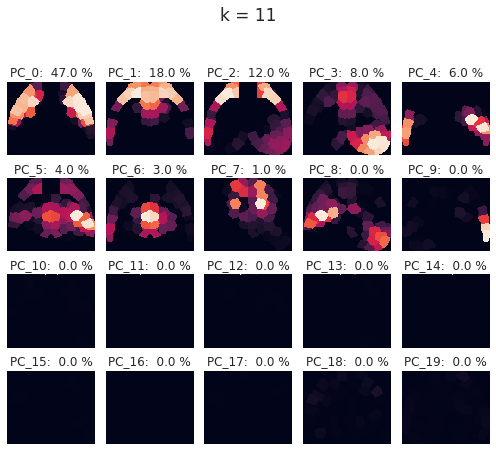

--------------------------------------------------------------------------------

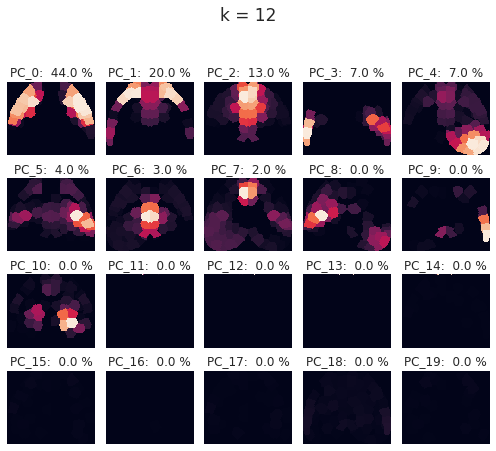

--------------------------------------------------------------------------------

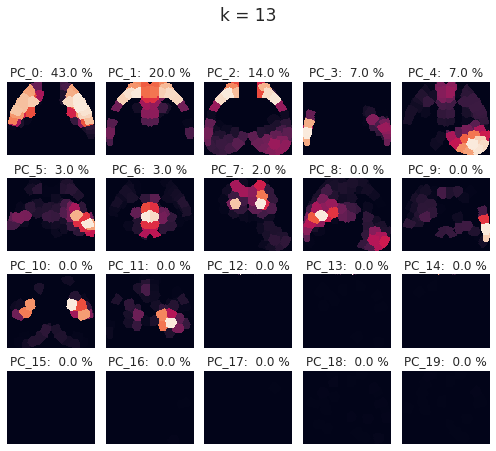

--------------------------------------------------------------------------------

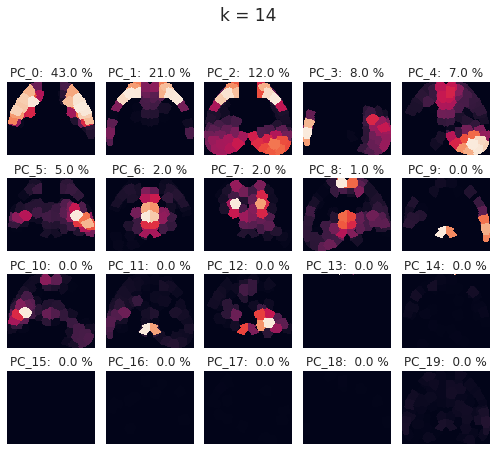

--------------------------------------------------------------------------------

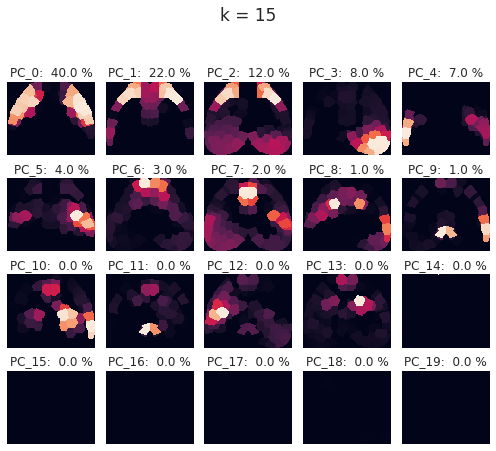

--------------------------------------------------------------------------------

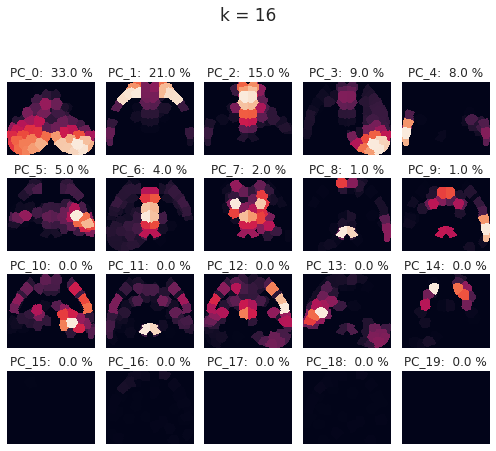

--------------------------------------------------------------------------------

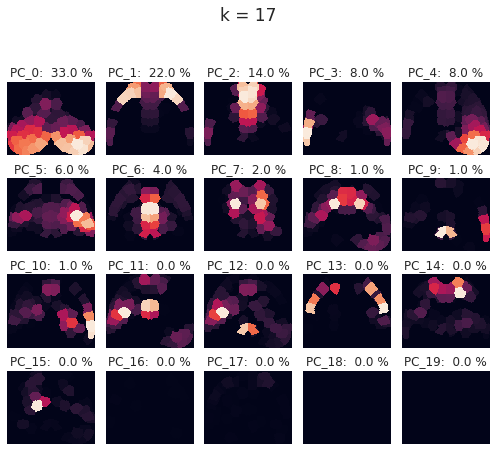

CPU times: user 10min 54s, sys: 39.4 s, total: 11min 33s
Wall time: 6min 40s


In [21]:
%%time

p = 20
y_avg_all = {}
pca_results = {}
for k in range(3, 18):
    svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
    group_dir = get_svinet_group_dir(
        results_dir=mice.cfg.results_dir,
        k=k,
        p=p,
        graph_type='real',
    )
    available = [
        e for e in os.listdir(group_dir)
        if '(0.2,1.0;4)' in e
    ]
    file = sorted(available, key=sort_date_latest)[-1]
    group = np.load(pjoin(group_dir, file), allow_pickle=True).item()
    _, y_avg = node_sim_matrix(group)
    y_avg_all[k] = y_avg
    pi_vol = svinet.pi2vol(y_avg, cortex_only=True)
    _results = node_sim_pca(pi_vol)
    pca_results[k] = _results
    
    print('-' * 80)
    fig, axes = create_figure(4, 5, (7, 6))
    for i, ax in enumerate(axes.ravel()):
        arr = _results['comps'][i]
        arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
        ax.imshow(arr)
        ax.set_title(f"PC_{i}:  {np.round(100 * _results['var_ratio'][i])} %")
    fig.suptitle(f"k = {k}", fontsize=17, y=1.05)
    remove_ticks(axes)
    plt.show()
    
    print('\n')

In [22]:
dlist = []
for k, result in pca_results.items():
    cumvar = np.cumsum(result['var_ratio'])
    dlist.append({
        'cumvar': cumvar,
        'k': [k] * len(cumvar),
        'comp': range(1, 1 + len(cumvar)),
    })
df_pca = pd.DataFrame(merge_dicts(dlist))

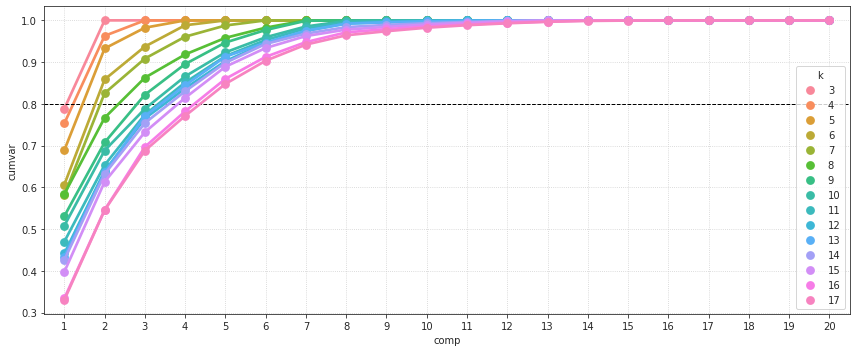

In [23]:
fig, ax = create_figure(1, 1, (12, 5))
sns.pointplot(
    data=df_pca,
    x='comp',
    y='cumvar',
    hue='k',
    ax=ax,
)
ax.axhline(0.8, color='k', ls='--', lw=1)
ax.grid()
plt.show()

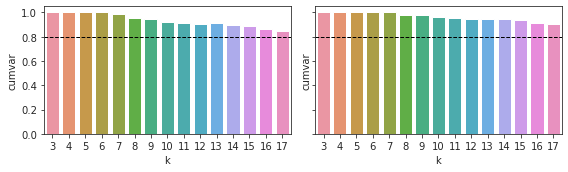

In [24]:
fig, axes = create_figure(1, 2, (8, 2.5), 'ticks', 'all', 'all')
for ncomp, ax in zip([5, 6], axes.ravel()):
    _df = df_pca.loc[df_pca.comp == ncomp]
    sns.barplot(data=_df, x='k', y='cumvar', ax=ax)
    ax.axhline(0.8, color='k', ls='--', lw=1)
    # ax.axhline(0.9, color='dimgrey', ls='--', lw=1)
    # ax.axhspan(0.8, 1.0, color='grey', alpha=0.5, zorder=0)

In [25]:
x_flat = np.concatenate([
    result['x_flat'] for k, result
    in pca_results.items() if k > 5
])
nonzero_ids = np.where(x_flat.sum(0) > 0)[0]
x_flat.shape, len(nonzero_ids)

((1656, 468180), 116936)

In [26]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=20,
    svd_solver='full',
).fit(x_flat[:, nonzero_ids])

comps = np.zeros((len(pca.components_), x_flat.shape[-1]))
comps[:, nonzero_ids] = pca.components_
comps = comps.reshape((-1, *result['shape'][1:]))

np.round(pca.explained_variance_ratio_ * 100)

array([47., 19., 11.,  7.,  6.,  3.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

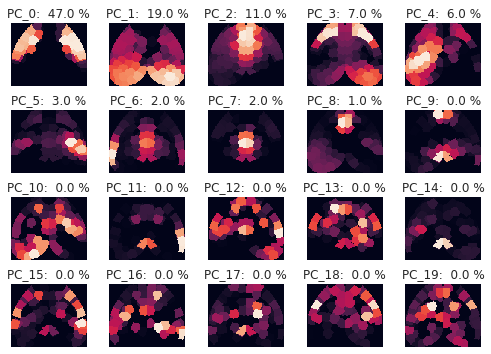

In [27]:
fig, axes = create_figure(4, 5, (7, 5))
for i, ax in enumerate(axes.ravel()):
    arr = comps[i]
    arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
    ax.imshow(arr)
    ax.set_title(f"PC_{i}:  {np.round(100 * pca.explained_variance_ratio_[i])} %")
remove_ticks(axes)
plt.show()

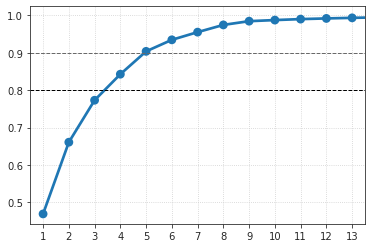

In [28]:
s = pd.Series(data=np.cumsum(pca.explained_variance_ratio_), index=range(1, 21))
sns.pointplot(x=s.index, y=s.values)
plt.axhline(0.8, color='k', ls='--', lw=1)
plt.axhline(0.9, color='dimgrey', ls='--', lw=1)
plt.xlim(-0.5, 12.5)
plt.grid()

In [29]:
_y_avg = np.concatenate([
    np.expand_dims(v, 0) for k, v in
    y_avg_all.items() if k > 10
])
_y_avg.shape

(7, 138, 138)

In [40]:
n_clusters = 5
svinet = SVINET(mice, n_clusters, p, 'sub-SLC', verbose=False)

comps, model = fit_kmeans(
    data=_y_avg.mean(0),# _y_avg.reshape(-1, _y_avg.shape[-1]),
    n_clusters=n_clusters,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
comps /= comps.sum(0, keepdims=True)
gmap = svinet.align_centroid_to_structs(comps)
comps = comps[gmap]
comps.shape

(5, 138)

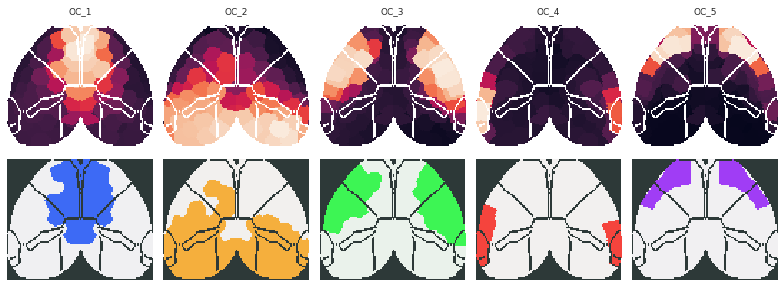

In [42]:
svinet.show(comps, figsize=(11, 4.2))

In [32]:
svinet.best_qs = [0.75]
svinet.path = tmp_dir
svinet.render(comps)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/overlap_cortex_k8.html

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/render/disjoint_cortex_k8.html

<matplotlib.colorbar.Colorbar object at 0x7fbe0bf6b310>

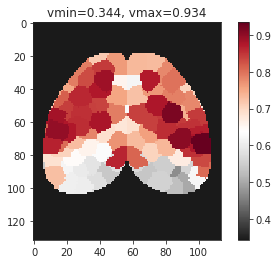

In [43]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h), cmap='RdGy_r')
plt.title(f"vmin={min(h):.3f}, vmax={max(h):.3f}")
plt.colorbar()

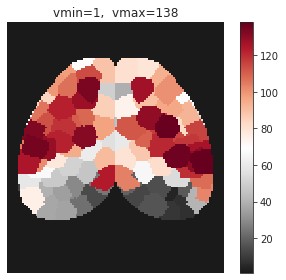

In [44]:
fig, ax = create_figure(1, 1, (5, 4))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
hr = sp_stats.rankdata(h)
mask = svinet.pi2arr(hr.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(hr), vmax=max(hr), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(hr):0.0f},  vmax={max(hr):0.0f}")
remove_ticks(ax)

<AxesSubplot:ylabel='Count'>

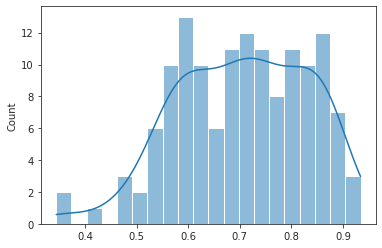

In [45]:
sns.histplot(h, bins=20, kde=True)

In [46]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(_y_avg.mean(0))

y_emb.shape

(138, 2)

In [47]:
hemis = np.array(['R'] * len(svinet.n2l))
hemis[svinet.l_ids] = 'L'

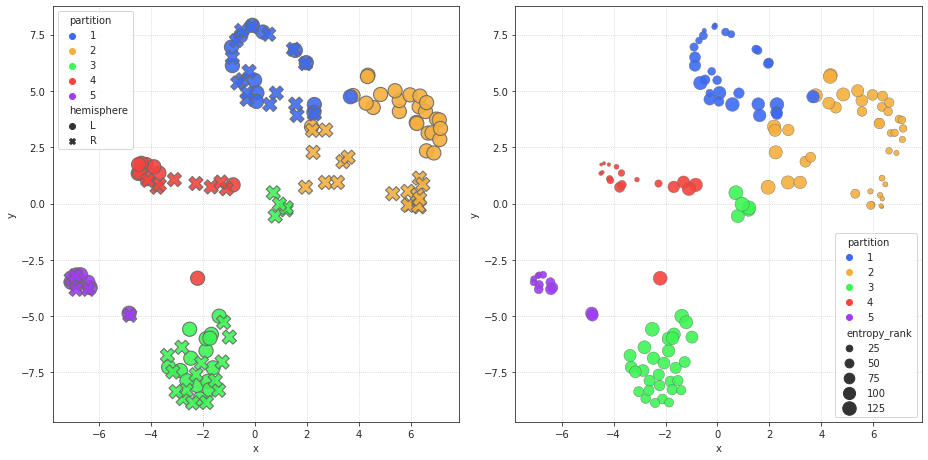

In [48]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
    'entropy_rank': hr,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    markers={'L': 'o', 'R': 'X'},
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy_rank',
    sizes=(10, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

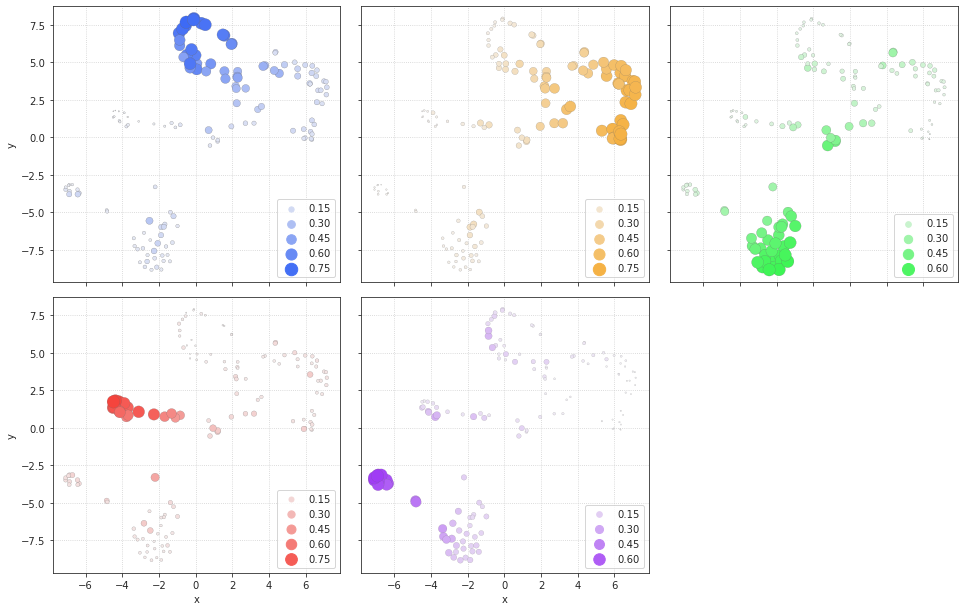

In [50]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'strength': comps[i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.legend(loc="lower right")
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()

## On config

In [11]:
%%time

p = 20
y_avg_all = {}
pca_results = {}
for k in tqdm(range(3, 18)):
    svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
    group_dir = get_svinet_group_dir(
        results_dir=mice.cfg.results_dir,
        k=k,
        p=p,
        graph_type='config',
    )
    available = [
        e for e in os.listdir(group_dir)
        if '(0.2,1.0;4)' in e
    ]
    file = sorted(available, key=sort_date_latest)[-1]
    group = np.load(pjoin(group_dir, file), allow_pickle=True).item()
    _, y_avg = node_sim_matrix(group)
    y_avg_all[k] = y_avg
    pi_vol = svinet.pi2vol(y_avg, cortex_only=True)
    _results = node_sim_pca(pi_vol)
    pca_results[k] = _results

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 9min 23s, sys: 37.7 s, total: 10min
Wall time: 5min 18s


In [12]:
dlist = []
for k, result in pca_results.items():
    cumvar = np.cumsum(result['var_ratio'])
    dlist.append({
        'cumvar': cumvar,
        'k': [k] * len(cumvar),
        'comp': range(1, 1 + len(cumvar)),
    })
df_pca = pd.DataFrame(merge_dicts(dlist))

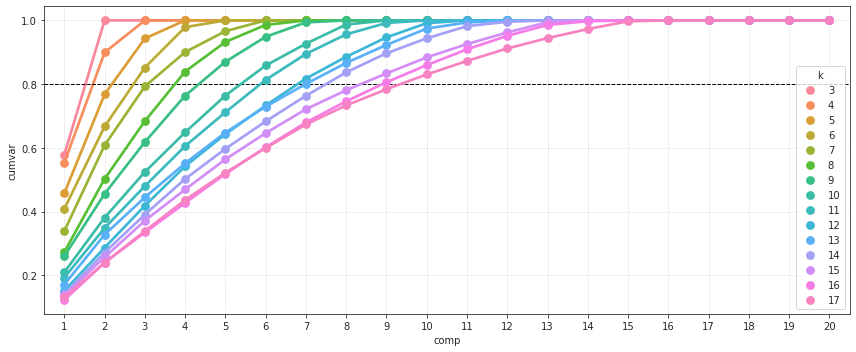

In [13]:
fig, ax = create_figure(1, 1, (12, 5))
sns.pointplot(
    data=df_pca,
    x='comp',
    y='cumvar',
    hue='k',
    ax=ax,
)
ax.axhline(0.8, color='k', ls='--', lw=1)
ax.grid()
plt.show()

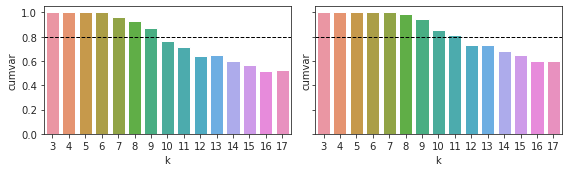

In [14]:
fig, axes = create_figure(1, 2, (8, 2.5), 'ticks', 'all', 'all')
for ncomp, ax in zip([5, 6], axes.ravel()):
    _df = df_pca.loc[df_pca.comp == ncomp]
    sns.barplot(data=_df, x='k', y='cumvar', ax=ax)
    ax.axhline(0.8, color='k', ls='--', lw=1)

In [15]:
x_flat = np.concatenate([
    result['x_flat'] for k, result
    in pca_results.items() if k > 5
])
nonzero_ids = np.where(x_flat.sum(0) > 0)[0]
x_flat.shape, len(nonzero_ids)

((1656, 468180), 116936)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=20,
    svd_solver='full',
).fit(x_flat[:, nonzero_ids])

comps = np.zeros((len(pca.components_), x_flat.shape[-1]))
comps[:, nonzero_ids] = pca.components_
comps = comps.reshape((-1, *result['shape'][1:]))

np.round(pca.explained_variance_ratio_ * 100)

array([51.,  7.,  5.,  4.,  4.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

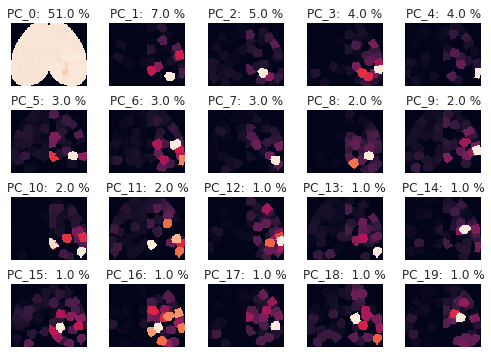

In [17]:
fig, axes = create_figure(4, 5, (7, 5))
for i, ax in enumerate(axes.ravel()):
    arr = comps[i]
    arr = project_vol_2d(arr, (arr.shape[0], arr.shape[-1]), 'max_proj')
    ax.imshow(arr)
    ax.set_title(f"PC_{i}:  {np.round(100 * pca.explained_variance_ratio_[i])} %")
remove_ticks(axes)
plt.show()

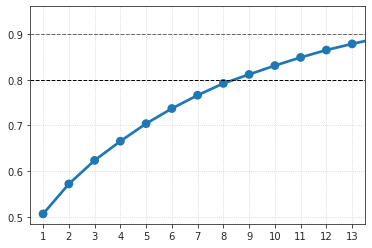

In [18]:
s = pd.Series(data=np.cumsum(pca.explained_variance_ratio_), index=range(1, 21))
sns.pointplot(x=s.index, y=s.values)
plt.axhline(0.8, color='k', ls='--', lw=1)
plt.axhline(0.9, color='dimgrey', ls='--', lw=1)
plt.xlim(-0.5, 12.5)
plt.grid()

In [19]:
_y_avg = np.concatenate([
    np.expand_dims(v, 0) for k, v in
    y_avg_all.items() if k > 10
])
_y_avg.shape

(7, 138, 138)

In [20]:
n_clusters = 5
svinet = SVINET(mice, n_clusters, p, 'sub-SLC', verbose=False)

comps, model = fit_kmeans(
    data=_y_avg.mean(0),# _y_avg.reshape(-1, _y_avg.shape[-1]),
    n_clusters=n_clusters,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
comps /= comps.sum(0, keepdims=True)
gmap = svinet.align_centroid_to_structs(comps)
comps = comps[gmap]
comps.shape

(5, 138)

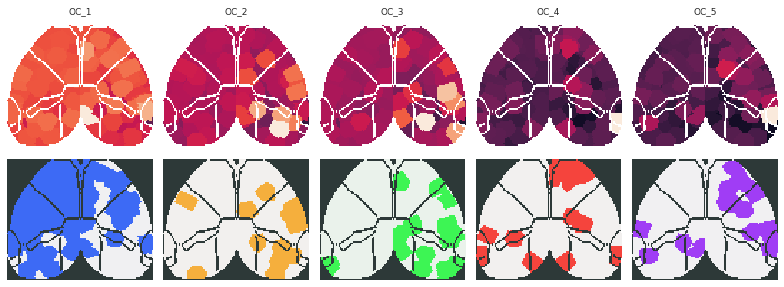

In [21]:
svinet.show(comps, figsize=(11, 4.2))

<matplotlib.colorbar.Colorbar object at 0x7f6b584e6190>

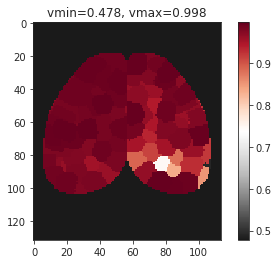

In [22]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h), cmap='RdGy_r')
plt.title(f"vmin={min(h):.3f}, vmax={max(h):.3f}")
plt.colorbar()

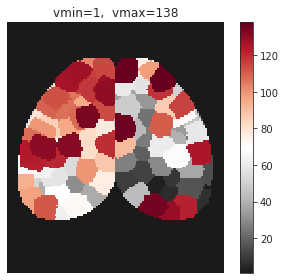

In [23]:
fig, ax = create_figure(1, 1, (5, 4))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
hr = sp_stats.rankdata(h)
mask = svinet.pi2arr(hr.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(hr), vmax=max(hr), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(hr):0.0f},  vmax={max(hr):0.0f}")
remove_ticks(ax)

<AxesSubplot:ylabel='Count'>

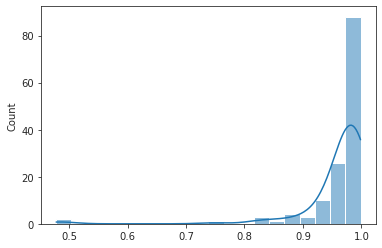

In [24]:
sns.histplot(h, bins=20, kde=True)

In [25]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(_y_avg.mean(0))

y_emb.shape

(138, 2)

In [26]:
hemis = np.array(['R'] * len(svinet.n2l))
hemis[svinet.l_ids] = 'L'

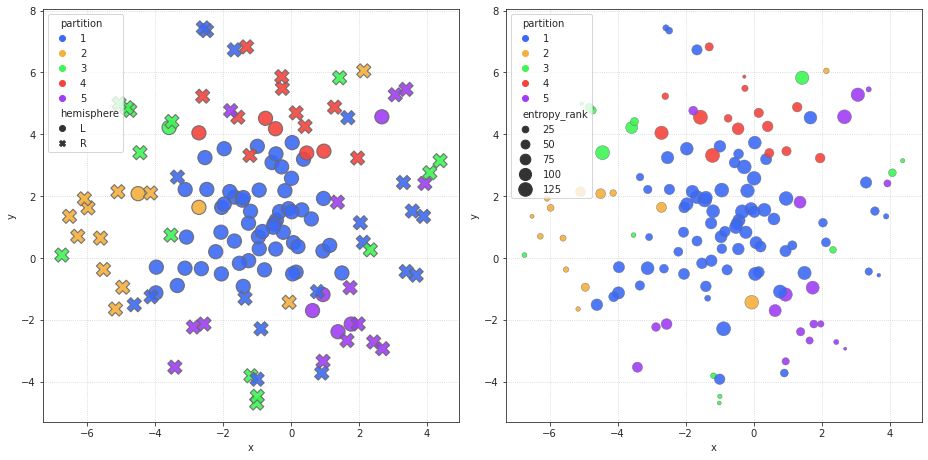

In [27]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
    'entropy_rank': hr,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    markers={'L': 'o', 'R': 'X'},
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy_rank',
    sizes=(10, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

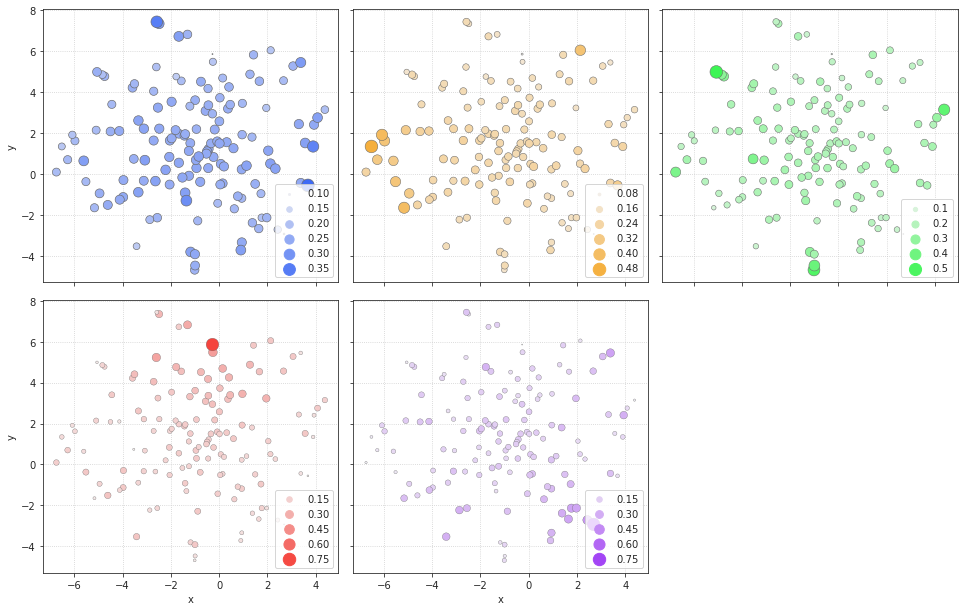

In [28]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'strength': comps[i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.legend(loc="lower right")
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()

## OLD stuff

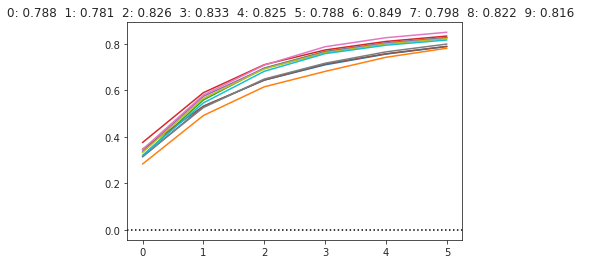

In [24]:


pcs = []
ttl = ''
for i in range(10):
    pi_vol = svinet.pi2vol(y[i], cortex_only=True)
    mask = functools.reduce(np.logical_or, [e != 0 for e in pi_vol.values()])
    x_list = filter_boundaries(list(pi_vol.values()), mask=mask)
    x = [np.expand_dims(e, axis=0) for e in x_list]
    x = np.concatenate(x)
    nans = np.isnan(x).sum(-1).astype(bool)
    pca = PCA(n_components=6, svd_solver='full', random_state=0).fit(x[~nans])
    comps = pca.components_.copy()
    pcs.append(comps)
    
    data2plt = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(data2plt, color=f"C{i}")
    ttl += f'{i}: {data2plt[-1]:.3f}  '
plt.title(ttl)
plt.axhline(0, ls=':', color='k')
plt.show()

In [10]:
from sklearn.decomposition import PCA

In [11]:
pi_vol = svinet.pi2vol(y_avg, cortex_only=True)
mask = functools.reduce(np.logical_or, [e > 0 for e in pi_vol.values()])
x_list = filter_boundaries(list(pi_vol.values()), mask=mask)
x = [np.expand_dims(e, axis=0) for e in x_list]
x = np.concatenate(x)
y_avg.shape, x.shape

((138, 138), (138, 85, 54, 102))

(132, 114)

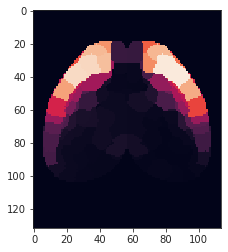

(132, 114)

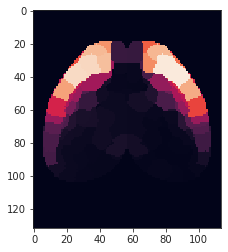

In [55]:
x2d = project_vol_2d(pi_vol[23], mice.allen['dims_flat'], 'max_proj')
plt.imshow(x2d)
x2d.shape

(132, 114)

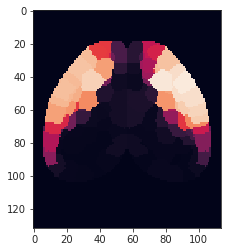

In [13]:
nans = np.isnan(x).sum(-1).sum(-1).sum(-1).astype(bool)
x_flat = x.reshape(len(x), -1)[~nans]

nonzero_ids = np.where(x_flat.sum(0) > 0)[0]
x_flat_nonzero = x_flat[:, nonzero_ids]
x_flat.shape, x_flat_nonzero.shape

((138, 468180), (138, 116936))

In [14]:
n_components = 20
pca = PCA(n_components=n_components, svd_solver='full').fit(x_flat)
comps = pca.components_.reshape((-1, *x.shape[1:])).copy()
comps.shape

(20, 85, 54, 102)

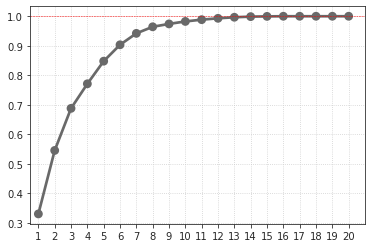

In [15]:
data2plt = np.cumsum(pca.explained_variance_ratio_)
data2plt = pd.Series(data=data2plt, index=range(1, 1 + len(data2plt)))
sns.pointplot(x=data2plt.index, y=data2plt.values, color='dimgrey')
plt.axhline(1.0, color='r', ls='--', lw=0.5)
plt.xlim(-0.5, 20)
plt.grid()

In [14]:
n_components = 20
pca = PCA(n_components=n_components, svd_solver='full').fit(x_flat_nonzero)
comps = np.zeros((n_components, x_flat.shape[-1]))
comps[:, nonzero_ids] = pca.components_
comps = comps.reshape((n_components, *x.shape[1:]))
comps.shape

(20, 85, 54, 102)

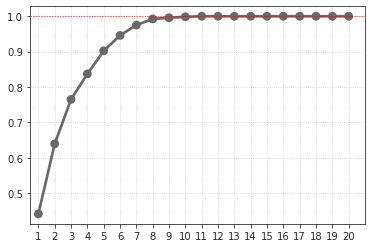

In [15]:
data2plt = np.cumsum(pca.explained_variance_ratio_)
data2plt = pd.Series(data=data2plt, index=range(1, 1 + len(data2plt)))
sns.pointplot(x=data2plt.index, y=data2plt.values, color='dimgrey')
plt.axhline(1.0, color='r', ls='--', lw=0.5)
plt.xlim(-0.5, 20)
plt.grid()

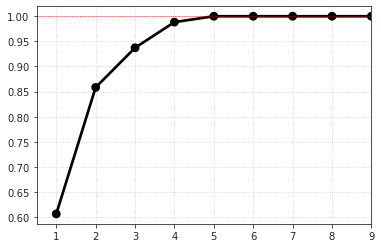

In [42]:
n_clusters = 5
svinet = SVINET(mice, n_clusters, p, 'sub-SLC', verbose=False)

comps, model = fit_kmeans(
    data=y_avg,
    n_clusters=n_clusters,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
comps /= comps.sum(0, keepdims=True)
gmap = svinet.align_centroid_to_structs(comps)
comps = comps[gmap]
comps.shape

(5, 138)

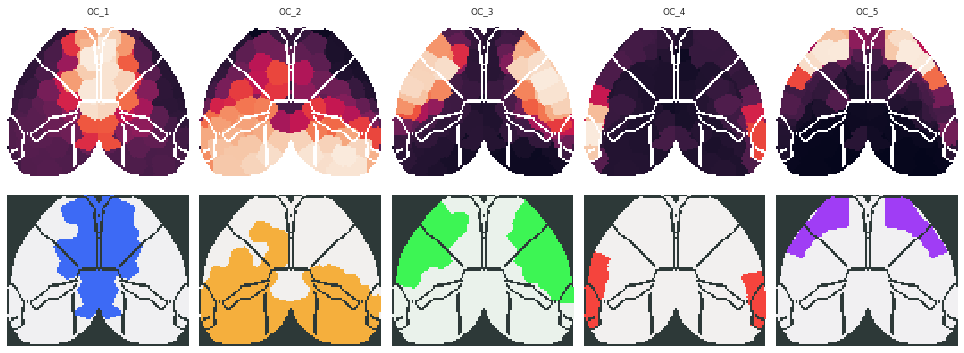

In [43]:
svinet.show(comps, figsize=(13.5, 5.2))

<matplotlib.colorbar.Colorbar object at 0x7f7362f61d30>

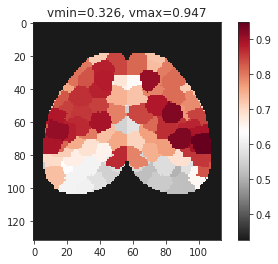

In [44]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h), cmap='RdGy_r')
plt.title(f"vmin={min(h):.3f}, vmax={max(h):.3f}")
plt.colorbar()

In [45]:
def map2interval(
    x: np.ndarray,
    interval: Tuple[float, float] = (0., 1.), ):
    
    a = interval[1] / (np.max(x) - np.min(x))
    b = - a * np.min(x)
    
    return a * x + b

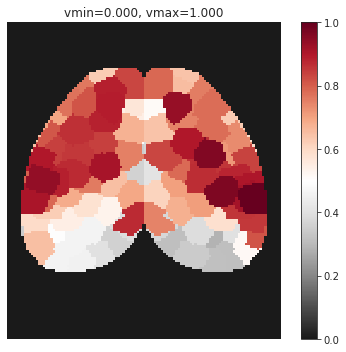

In [46]:
fig, ax = create_figure(1, 1, (6, 5))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
h = map2interval(h)
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(h), vmax=max(h), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(h):0.3f}, vmax={max(h):0.3f}")
remove_ticks(ax)


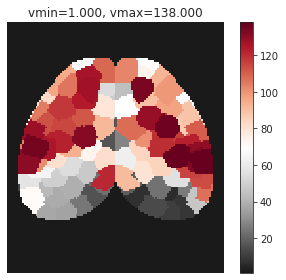

In [47]:
fig, ax = create_figure(1, 1, (5, 4))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
hr = sp_stats.rankdata(h)
mask = svinet.pi2arr(hr.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(hr), vmax=max(hr), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(hr):0.3f}, vmax={max(hr):0.3f}")
remove_ticks(ax)

<AxesSubplot:ylabel='Count'>

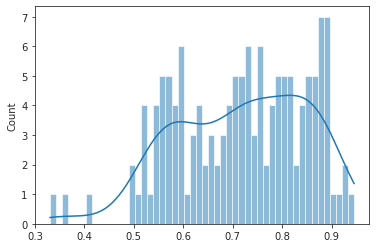

In [22]:
sns.histplot(h, bins=50, kde=True)

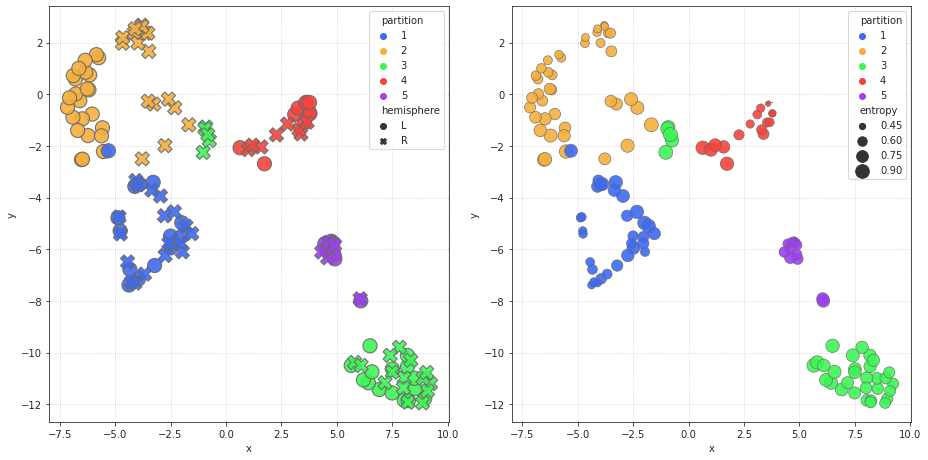

In [34]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    markers={'L': 'o', 'R': 'X'},
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy',
    sizes=(1, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

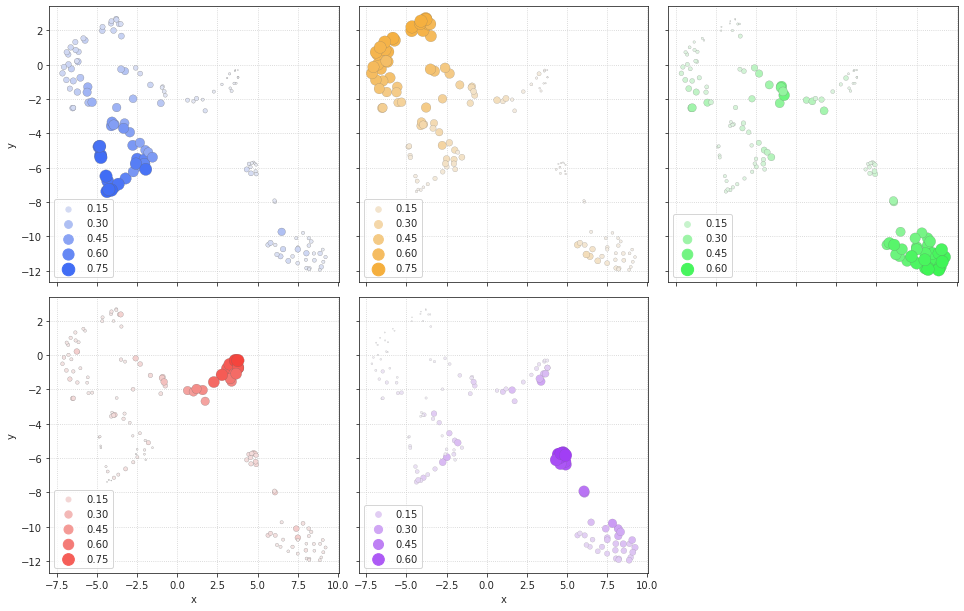

In [35]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'strength': comps[i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.legend(loc="lower left")
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()

In [52]:
a = np.nanmean(np.nanmean(group['gam_all'],  2), 1)
eh_avg = np.nanmean(entropy_expect_beta(a), 0)
eh_avg = map2interval(eh_avg)

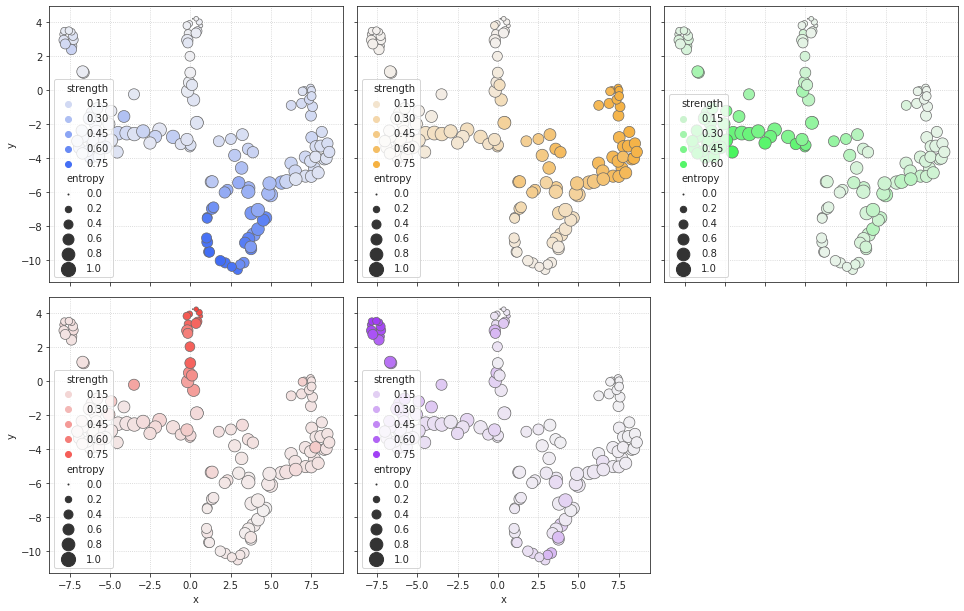

In [53]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'strength': comps[i, :],
        'entropy': eh_avg,
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='entropy',
        sizes=(1, 200),
        palette=svinet.cmaps[i+1],
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()

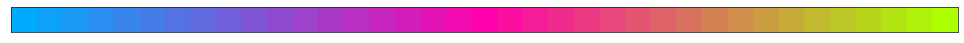

In [54]:
ramp_colors = ['#00abff', '#ff00ab', '#abff00']
cmap = make_cmap(ramp_colors, name='overlap')

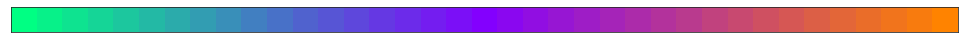

In [55]:
ramp_colors = ['#00ff83', '#8300ff', '#ff8300']
cmap = make_cmap(ramp_colors, name='overlap')

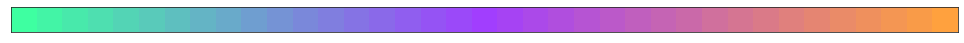

In [56]:
ramp_colors = ['#3effa1', '#a13eff', '#ffa13e']
cmap = make_cmap(ramp_colors, name='overlap')

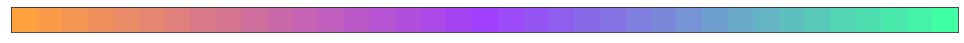

In [57]:
ramp_colors = ['#ffa13e', '#a13eff', '#3effa1']
cmap = make_cmap(ramp_colors, name='overlap')

In [58]:
comps.shape

(5, 138)

In [59]:
comps[:, 50]

array([0.03088329, 0.03345949, 0.03726542, 0.83124063, 0.06715118])

In [60]:
comps_condensed = np.zeros((3, comps.shape[-1]))
comps_condensed[0] = comps[1]
comps_condensed[1] = comps[0] + comps[3:].sum(0)
comps_condensed[2] = comps[2]

[
    <matplotlib.lines.Line2D object at 0x7fcd30939610>,
    <matplotlib.lines.Line2D object at 0x7fcd30939700>,
    <matplotlib.lines.Line2D object at 0x7fcd309397c0>
]

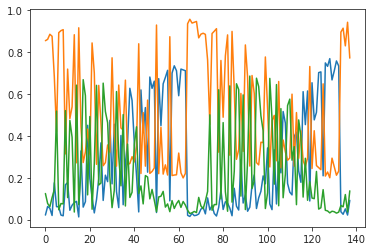

In [61]:
plt.plot(comps_condensed.T)

In [62]:
partition = np.argmax(comps, axis=0)

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
h = map2interval(h)
sord_ids = np.argsort(h)

[
    <matplotlib.lines.Line2D object at 0x7fcca8296670>,
    <matplotlib.lines.Line2D object at 0x7fcca8296760>,
    <matplotlib.lines.Line2D object at 0x7fcca8296820>
]

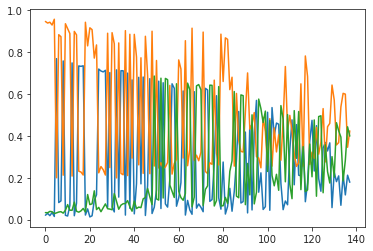

In [63]:
plt.plot(comps_condensed.T[sord_ids])

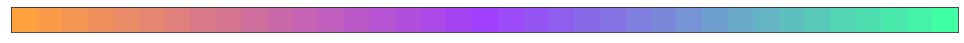

In [64]:
ramp_colors = ['#ffa13e', '#a13eff', '#3effa1']
cmap = make_cmap(ramp_colors, name='overlap')

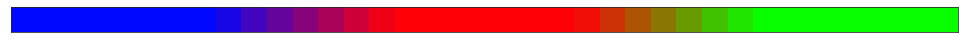

In [65]:
repeat = 2
# ramp_colors = ['#ffa13e', '#a13eff', '#3effa1']
ramp_colors = ['#0007ff', '#ff0007', '#07ff00']
# ramp_colors = ['#f5af3d', '#af3df5', '#3df5af']
# ramp_colors = ['#fffe00', '#fe00ff', '#00fffe']
cmap = make_cmap(np.repeat(ramp_colors, repeat), name='overlap')

In [66]:
vals = {}
colors = {}
for node in range(comps_condensed.shape[-1]):
    ids = np.argsort(comps_condensed[:, node])[::-1]
    a, b = comps_condensed[:, node][ids][:2]
    val = b / (a + b)
    ramp = [ramp_colors[ids[0]]] * repeat + [ramp_colors[ids[1]]] * repeat
    _cmap = make_cmap(ramp, show=False)
    colors[node] = rgb2hex(_cmap(val))
    vals[node] = val

<AxesSubplot:ylabel='Density'>

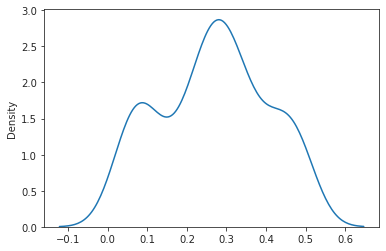

In [67]:
sns.kdeplot(vals.values())

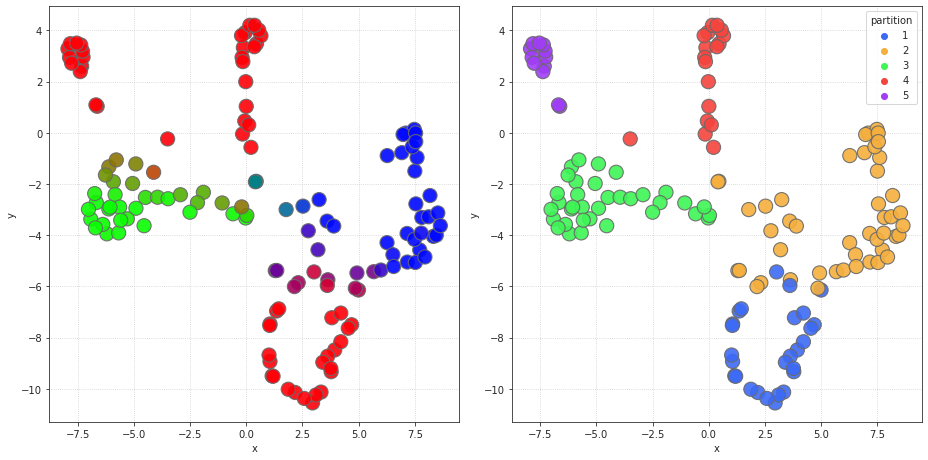

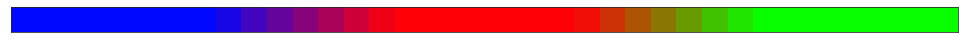

In [68]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
s = sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()
display_cmap(cmap)

In [69]:
vals = {}
colors = {}
for node in range(comps.shape[-1]):
    ids = np.argsort(comps[:, node])[::-1]
    a, b = comps[:, node][ids][:2]
    val = b / (a + b)
    ramp = [svinet.colors[1 + ids[0]]] * 2 + [svinet.colors[1 + ids[1]]] * 2
    cmap = make_cmap(ramp, show=False)
    colors[node] = rgb2hex(cmap(val))
    vals[node] = val

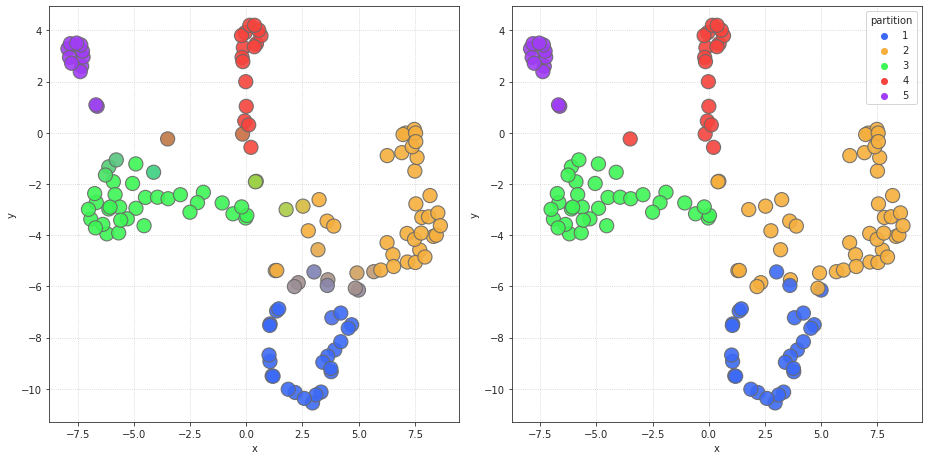

In [70]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

<AxesSubplot:>

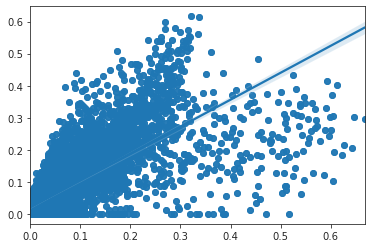

In [72]:
a = y_avg.copy().astype(float)
np.fill_diagonal(a, 0.)
a = a.ravel()
b = svinet.adjacencies[66].ravel()
sns.regplot(x=a, y=b)

In [74]:
from sklearn.manifold import MDS
y_emb = MDS(
    n_components=2,
    n_init=10,
    random_state=mice.cfg.random_state,
).fit_transform(y_avg)

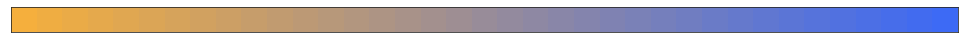

In [75]:
cmap = make_cmap([svinet.colors[2], svinet.colors[1]])

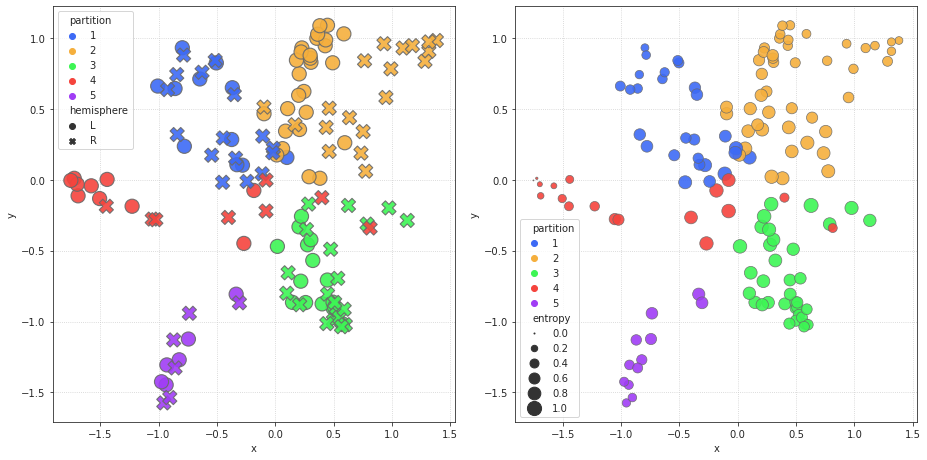

In [76]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy',
    sizes=(1, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

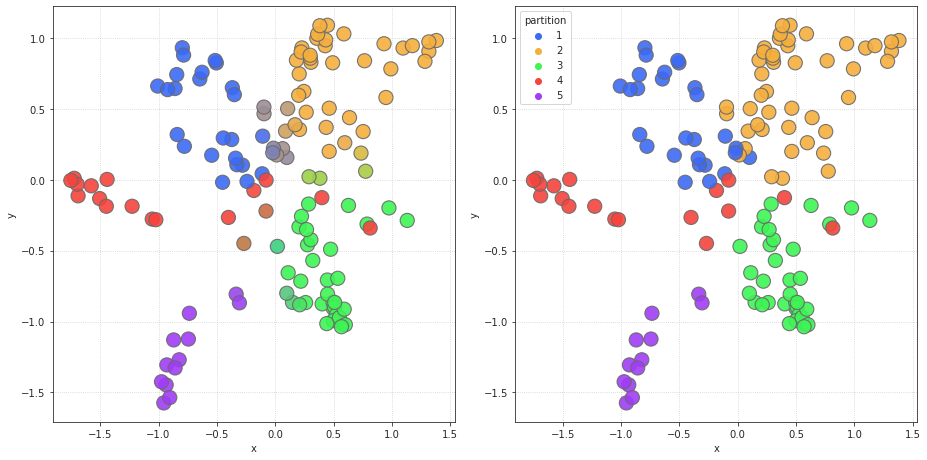

In [77]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

In [78]:
from karateclub import Node2Vec

model = Node2Vec(
    walk_number=20,
    walk_length=80,
    p=1.0,
    q=1.0,
    dimensions=138,
    workers=4,
    window_size=5,
    epochs=1,
    learning_rate=0.05,
    min_count=1,
    seed=mice.cfg.random_state,
)
model.fit(svinet.graphs[20])
_x_emb = model.get_embedding()

In [79]:
_x_emb.shape

(138, 138)

In [80]:
x_emb = MDS(
    n_components=2,
    n_init=10,
    random_state=mice.cfg.random_state,
).fit_transform(_x_emb)

NameError: name 'x_emb' is not defined

In [81]:
x_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(_x_emb)

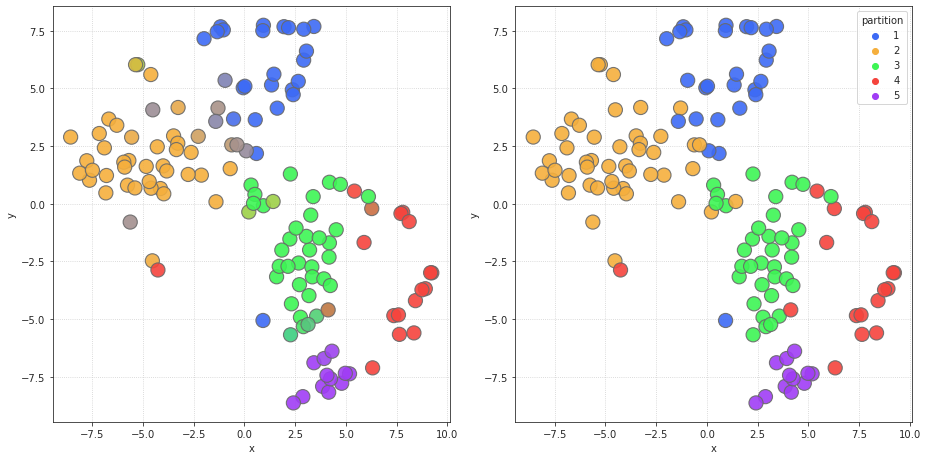

In [82]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

In [ ]:
pi_avg = np.nanmean(pi_real, 0)
pi_avg.shape, pi_real.shape

In [ ]:
y_link = np.einsum('ki, kj -> kij', pi_avg, pi_avg)
y_link.shape

In [ ]:
y_link[:, 51, 25] - pi_avg[:, 51] * pi_avg[:, 25]

In [ ]:
y_link[:, 25, 25]

In [ ]:
y_link_flat = [
    np.expand_dims(y_link[i][np.triu_indices(pi_avg.shape[1])], 0)
    for i in range(k)
]
y_link_flat = np.concatenate(y_link_flat)
y_link_flat.shape

In [ ]:
adj_link = y_link_flat.T @ y_link_flat

In [ ]:
np.min(adj_link), np.max(adj_link)

In [ ]:
sns.histplot(adj_link[adj_link > 0.03], bins=10)
plt.yscale('log')

## Posterior update

In [ ]:
group['gam'].shape, group['pi'].shape

In [ ]:
mode = np.zeros_like(group['gam'])
for node in range(group['gam'].shape[1]):
    for i in range(k):
        mode[i, node] = (group['gam'][i, node] - 1) / (group['gam'][:, node].sum() - k)